## First try at getting some data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re

#API imports
from sodapy import Socrata

#SQL related
import psycopg2
import sqlite3
from sqlalchemy import create_engine
import pandas.io.sql as pd_sql

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shapely
from shapely.geometry import Point
# import contextily as ctx

#Regression imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn import feature_selection as f_select
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

from sklearn.pipeline import make_pipeline

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load all the data into an SQL database

In [3]:
# Set up the database connection
conn = psycopg2.connect(dbname="taxi_rides_db", user="auste_m")

In [4]:
# CREATE TABLE taxi_rides_clean (
#                             trip_id TEXT, 
#                             taxi_id TEXT, 
#                             trip_start_timestamp TIMESTAMP,
#                             trip_end_timestamp TIMESTAMP,
#                             trip_seconds INT,
#                             trip_miles FLOAT,
#                             pickup_census_tract TEXT,
#                             pickup_community_area TEXT,
#                             dropoff_census_tract TEXT,
#                             dropoff_community_area TEXT,
#                             fare FLOAT,
#                             tips FLOAT,
#                             tolls FLOAT,
#                             extras FLOAT,
#                             trip_total FLOAT,
#                             payment_type TEXT,
#                             company TEXT,
#                             pickup_centroid_latitude FLOAT,
#                             pickup_centroid_longitude FLOAT,
#                             pickup_centroid_location TEXT,
#                             dropoff_centroid_latitude FLOAT,
#                             dropoff_centroid_longitude FLOAT,
#                             dropoff_centroid_location TEXT
#                         );

In [5]:
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips.csv' DELIMITER ',' CSV HEADER;
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips_2016.csv' DELIMITER ',' CSV HEADER;

In [6]:
# CREATE TABLE chicago_weather(
#                                 station TEXT,
#                                 name TEXT, 
#                                 latitude FLOAT,
#                                 longitude FLOAT,
#                                 elevation FLOAT,
#                                 date TIMESTAMP, 
#                                 avg_daily_wind_speed FLOAT,
#                                 peak_gust_time FLOAT,
#                                 precipitation_mm FLOAT,
#                                 snowfall_mm FLOAT,
#                                 snowdepth_mm FLOAT,
#                                 avg_temp_f INT,
#                                 fog INT,
#                                 heavy_fog INT,
#                                 thunder INT,
#                                 sleet INT,
#                                 hail INT, 
#                                 glaze INT,
#                                 smoke INT,
#                                 drifting_snow INT, 
#                                 mist INT,
#                                 drizzle INT,
#                                 rain INT,
#                                 freezing_rain INT,
#                                 snow INT,
#                                 unkwn_precipitation INT,
#                                 ice_fog INT
#                                  );

In [7]:
# COPY chicago_weather FROM '/home/ubuntu/Chicago_Historical_Weather_Dataset.csv' DELIMITER ',' CSV HEADER;

In [8]:
taxi_rides_query = """SELECT * FROM taxi_rides WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-15';""" 
weather_query = """SELECT * FROM chicago_weather WHERE date BETWEEN '2016-02-01' AND '2016-02-15';"""

taxi_weather_query = """SELECT TR.trip_start_timestamp,
                                TR.trip_end_timestamp,
                                TR.trip_seconds,
                                TR.trip_miles,
                                --TR.pickup_community_area,
                                --TR.dropoff_community_area,
                                TR.fare,
                                TR.tips,
                                TR.tolls,
                                TR.extras,
                                TR.trip_total,
                                TR.payment_type,
                                TR.pickup_centroid_latitude,
                                TR.pickup_centroid_longitude,
                                TR.pickup_centroid_location,
                                TR.dropoff_centroid_latitude,
                                TR.dropoff_centroid_longitude,
                                TR.dropoff_centroid_location,
                                CW.avg_daily_wind_speed,
                                CW.avg_temp_f,
                                CASE WHEN CW.fog = 1 OR CW.heavy_fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END as fog,
                                CASE WHEN CW.rain = 1 OR CW.drizzle = 1 OR CW.hail = 1 THEN 1 ELSE 0 END as rain,
                                CASE WHEN CW.snow = 1 OR CW.freezing_rain = 1 OR drifting_snow = 1 THEN 1 ELSE 0 END as snow
                                
                        FROM taxi_rides_clean as TR
                        LEFT JOIN chicago_weather as CW
                        ON CAST(TR.trip_start_timestamp AS DATE) = CAST(date AS DATE)
                        WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-15';""" 

In [9]:
#Read in Chicago city community area shapefile
# chicago_community_areas = gpd.read_file("./datasets/Chicago_Community_Areas/geo_export_4c20eda0-2d92-4a1d-8513-878eb3e095a3.shp")

In [10]:
#approx. 30min to load the whole of 2016 data
taxi_weather_df = pd.read_sql_query(taxi_weather_query, con=conn)

In [11]:
taxi_weather_df.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,...,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2016-02-01 09:45:00,2016-02-01 09:45:00,180.0,0.5,4.75,0.0,0.0,0.0,4.75,Cash,...,-87.620993,POINT (-87.6209929134 41.8849871918),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),4.92,36,1,0,0
1,2016-02-01 07:30:00,2016-02-01 07:30:00,360.0,1.1,6.25,0.0,0.0,0.0,6.25,Cash,...,-87.632746,POINT (-87.6327464887 41.8809944707),41.895033,-87.619711,POINT (-87.6197106717 41.8950334495),4.92,36,1,0,0
2,2016-02-01 08:45:00,2016-02-01 09:00:00,360.0,1.6,7.50,0.0,0.0,0.0,7.50,Cash,...,-87.626146,POINT (-87.6261455896 41.9027880476),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),4.92,36,1,0,0
3,2016-02-01 16:45:00,2016-02-01 17:00:00,600.0,4.2,13.25,0.0,0.0,0.0,13.25,Cash,...,-87.699155,POINT (-87.6991553432 41.9227606205),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),4.92,36,1,0,0
4,2016-02-01 08:15:00,2016-02-01 08:15:00,0.0,0.0,3.25,0.0,0.0,0.0,3.25,Cash,...,-87.635891,POINT (-87.6358909539 41.9292629902),NaN,NaN,None,4.92,36,1,0,0


In [12]:
#Let's explore the dataset
# taxi_weather_df[taxi_weather_df['pickup_centroid_latitude'].isnull()].info()                    #287,350 records are missing pickup coordinates (17%)
# taxi_weather_df[taxi_weather_df['dropoff_centroid_latitude'].isnull() == True].info()           #311,728 records are missing pickup coordinates (18%)
# taxi_weather_df[(taxi_weather_df['pickup_centroid_latitude'].isnull()) == True | (taxi_weather_df['dropoff_centroid_latitude'].isnull()) == True].info()
taxi_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697009 entries, 0 to 1697008
Data columns (total 21 columns):
trip_start_timestamp          datetime64[ns]
trip_end_timestamp            datetime64[ns]
trip_seconds                  float64
trip_miles                    float64
fare                          float64
tips                          float64
tolls                         float64
extras                        float64
trip_total                    float64
payment_type                  object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
pickup_centroid_location      object
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dropoff_centroid_location     object
avg_daily_wind_speed          float64
avg_temp_f                    int64
fog                           int64
rain                          int64
snow                          int64
dtypes: datetime64[ns](2), float64(12), int64(4), object(3)
memory usage: 271.9+ MB


> **321,366** records are missing pickup or dropoff coordinates (**19%**)

## Sweeping time!

In [13]:
#Change payment type to boolean
taxi_weather_df['payment_type'] = pd.Categorical(taxi_weather_df['payment_type'])

In [14]:
#Let's drop all the records with a missing lat / long in either pickup or dropoff
taxi_weather_df.dropna(subset=['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                              'trip_seconds', 'trip_miles'], inplace=True)

### Update location columns for pickup and dropoff using shapely (converting the dataframe to GeoPandas)

In [18]:
#replace pickup_centroid_location and dropoff_centroid_location columns with point coordinates using shapely
pickup_geopoint = list(zip(taxi_weather_df['pickup_centroid_longitude'], taxi_weather_df['pickup_centroid_latitude']))
dropoff_geopoint = list(zip(taxi_weather_df['dropoff_centroid_longitude'], taxi_weather_df['dropoff_centroid_latitude']))

taxi_weather_df['pickup_centroid_location'] = pickup_geopoint
taxi_weather_df['dropoff_centroid_location'] = dropoff_geopoint

taxi_weather_df['pickup_centroid_location'] = taxi_weather_df['pickup_centroid_location'].apply(Point)
taxi_weather_df['dropoff_centroid_location'] = taxi_weather_df['dropoff_centroid_location'].apply(Point)


In [19]:
taxi_weather_df.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,...,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2016-02-01 09:45:00,2016-02-01 09:45:00,180.0,0.5,4.75,0.0,0.0,0.0,4.75,Cash,...,-87.620993,POINT (-87.62099291299999 41.884987192),41.880994,-87.632746,POINT (-87.632746489 41.880994471),4.92,36,1,0,0
1,2016-02-01 07:30:00,2016-02-01 07:30:00,360.0,1.1,6.25,0.0,0.0,0.0,6.25,Cash,...,-87.632746,POINT (-87.632746489 41.880994471),41.895033,-87.619711,POINT (-87.619710672 41.89503345),4.92,36,1,0,0
2,2016-02-01 08:45:00,2016-02-01 09:00:00,360.0,1.6,7.50,0.0,0.0,0.0,7.50,Cash,...,-87.626146,POINT (-87.62614558999999 41.902788048),41.880994,-87.632746,POINT (-87.632746489 41.880994471),4.92,36,1,0,0
3,2016-02-01 16:45:00,2016-02-01 17:00:00,600.0,4.2,13.25,0.0,0.0,0.0,13.25,Cash,...,-87.699155,POINT (-87.699155343 41.92276062),41.899602,-87.633308,POINT (-87.63330803700001 41.899602111),4.92,36,1,0,0
5,2016-02-01 23:15:00,2016-02-01 23:15:00,480.0,2.9,10.25,0.0,0.0,0.0,10.25,Cash,...,-87.633308,POINT (-87.63330803700001 41.899602111),41.901207,-87.676356,POINT (-87.676355989 41.901206994),4.92,36,1,0,0


In [21]:
taxi_weather_gdf = gpd.GeoDataFrame(taxi_weather_df, geometry='pickup_centroid_location')

In [22]:
taxi_weather_gdf.tail()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,...,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
1697002,2016-02-29,2016-02-29 00:00:00,420.0,0.0,8.00,0.0,0.0,1.0,9.00,Cash,...,-87.687516,POINT (-87.687515515 41.975170943),42.001571,-87.695013,POINT (-87.695012589 42.001571027),14.99,41,0,0,0
1697003,2016-02-29,2016-02-29 00:15:00,240.0,0.9,5.50,0.0,0.0,0.0,5.50,Cash,...,-87.653244,POINT (-87.653243992 41.952822916),41.963633,-87.652365,POINT (-87.652365359 41.963633169),14.99,41,0,0,0
1697005,2016-02-29,2016-02-29 00:00:00,120.0,0.9,5.25,0.0,0.0,0.0,5.25,Cash,...,-87.676356,POINT (-87.676355989 41.901206994),41.901207,-87.676356,POINT (-87.676355989 41.901206994),14.99,41,0,0,0
1697007,2016-02-29,2016-02-29 00:00:00,360.0,1.8,8.00,0.0,0.0,0.0,8.00,Cash,...,-87.632746,POINT (-87.632746489 41.880994471),41.859350,-87.617358,POINT (-87.617358006 41.859349715),14.99,41,0,0,0
1697008,2016-02-29,2016-02-29 00:00:00,0.0,8.9,3.25,0.0,0.0,0.0,3.25,Cash,...,-87.683835,POINT (-87.683834942 41.947791586),41.947792,-87.683835,POINT (-87.683834942 41.947791586),14.99,41,0,0,0


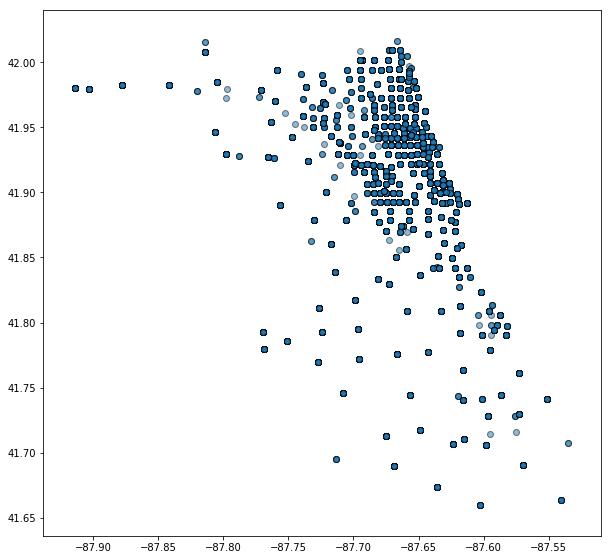

In [23]:
# df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# # We restrict to North America.
# ax = world[world.continent == 'North America'].plot(
#     color='white', edgecolor='blue')

# # We can now plot our GeoDataFrame.
# taxi_weather_gdf.plot(ax=ax, color='red')
# plt.show()

taxi_weather_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k');

## Cleaning Fun

### Helper Functions

In [24]:
# def dollar_to_float(string):
#     """Converts text columns with dollar sign into floats (after removing the currency sign)"""
#     pattern = re.compile('\$+')
#     old_value = string
#     new_value = 0.0
#     try:
#         new_value = re.sub(pattern, '', old_value)
#         new_value = float(new_value)
#     except:
#         ValueError
#     return new_value



In [25]:
#Recalculate the base fare


In [26]:
taxi_weather_gdf.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,...,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2016-02-01 09:45:00,2016-02-01 09:45:00,180.0,0.5,4.75,0.0,0.0,0.0,4.75,Cash,...,-87.620993,POINT (-87.62099291299999 41.884987192),41.880994,-87.632746,POINT (-87.632746489 41.880994471),4.92,36,1,0,0
1,2016-02-01 07:30:00,2016-02-01 07:30:00,360.0,1.1,6.25,0.0,0.0,0.0,6.25,Cash,...,-87.632746,POINT (-87.632746489 41.880994471),41.895033,-87.619711,POINT (-87.619710672 41.89503345),4.92,36,1,0,0
2,2016-02-01 08:45:00,2016-02-01 09:00:00,360.0,1.6,7.50,0.0,0.0,0.0,7.50,Cash,...,-87.626146,POINT (-87.62614558999999 41.902788048),41.880994,-87.632746,POINT (-87.632746489 41.880994471),4.92,36,1,0,0
3,2016-02-01 16:45:00,2016-02-01 17:00:00,600.0,4.2,13.25,0.0,0.0,0.0,13.25,Cash,...,-87.699155,POINT (-87.699155343 41.92276062),41.899602,-87.633308,POINT (-87.63330803700001 41.899602111),4.92,36,1,0,0
5,2016-02-01 23:15:00,2016-02-01 23:15:00,480.0,2.9,10.25,0.0,0.0,0.0,10.25,Cash,...,-87.633308,POINT (-87.63330803700001 41.899602111),41.901207,-87.676356,POINT (-87.676355989 41.901206994),4.92,36,1,0,0


In [27]:
# taxi_weather_gdf[taxi_weather_gdf['dropoff_centroid_longitude'].isnull()].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 0 entries
Data columns (total 21 columns):
trip_start_timestamp          0 non-null datetime64[ns]
trip_end_timestamp            0 non-null datetime64[ns]
trip_seconds                  0 non-null float64
trip_miles                    0 non-null float64
fare                          0 non-null float64
tips                          0 non-null float64
tolls                         0 non-null float64
extras                        0 non-null float64
trip_total                    0 non-null float64
payment_type                  0 non-null category
pickup_centroid_latitude      0 non-null float64
pickup_centroid_longitude     0 non-null float64
pickup_centroid_location      0 non-null object
dropoff_centroid_latitude     0 non-null float64
dropoff_centroid_longitude    0 non-null float64
dropoff_centroid_location     0 non-null object
avg_daily_wind_speed          0 non-null float64
avg_temp_f                    0 non-null int64
fog   

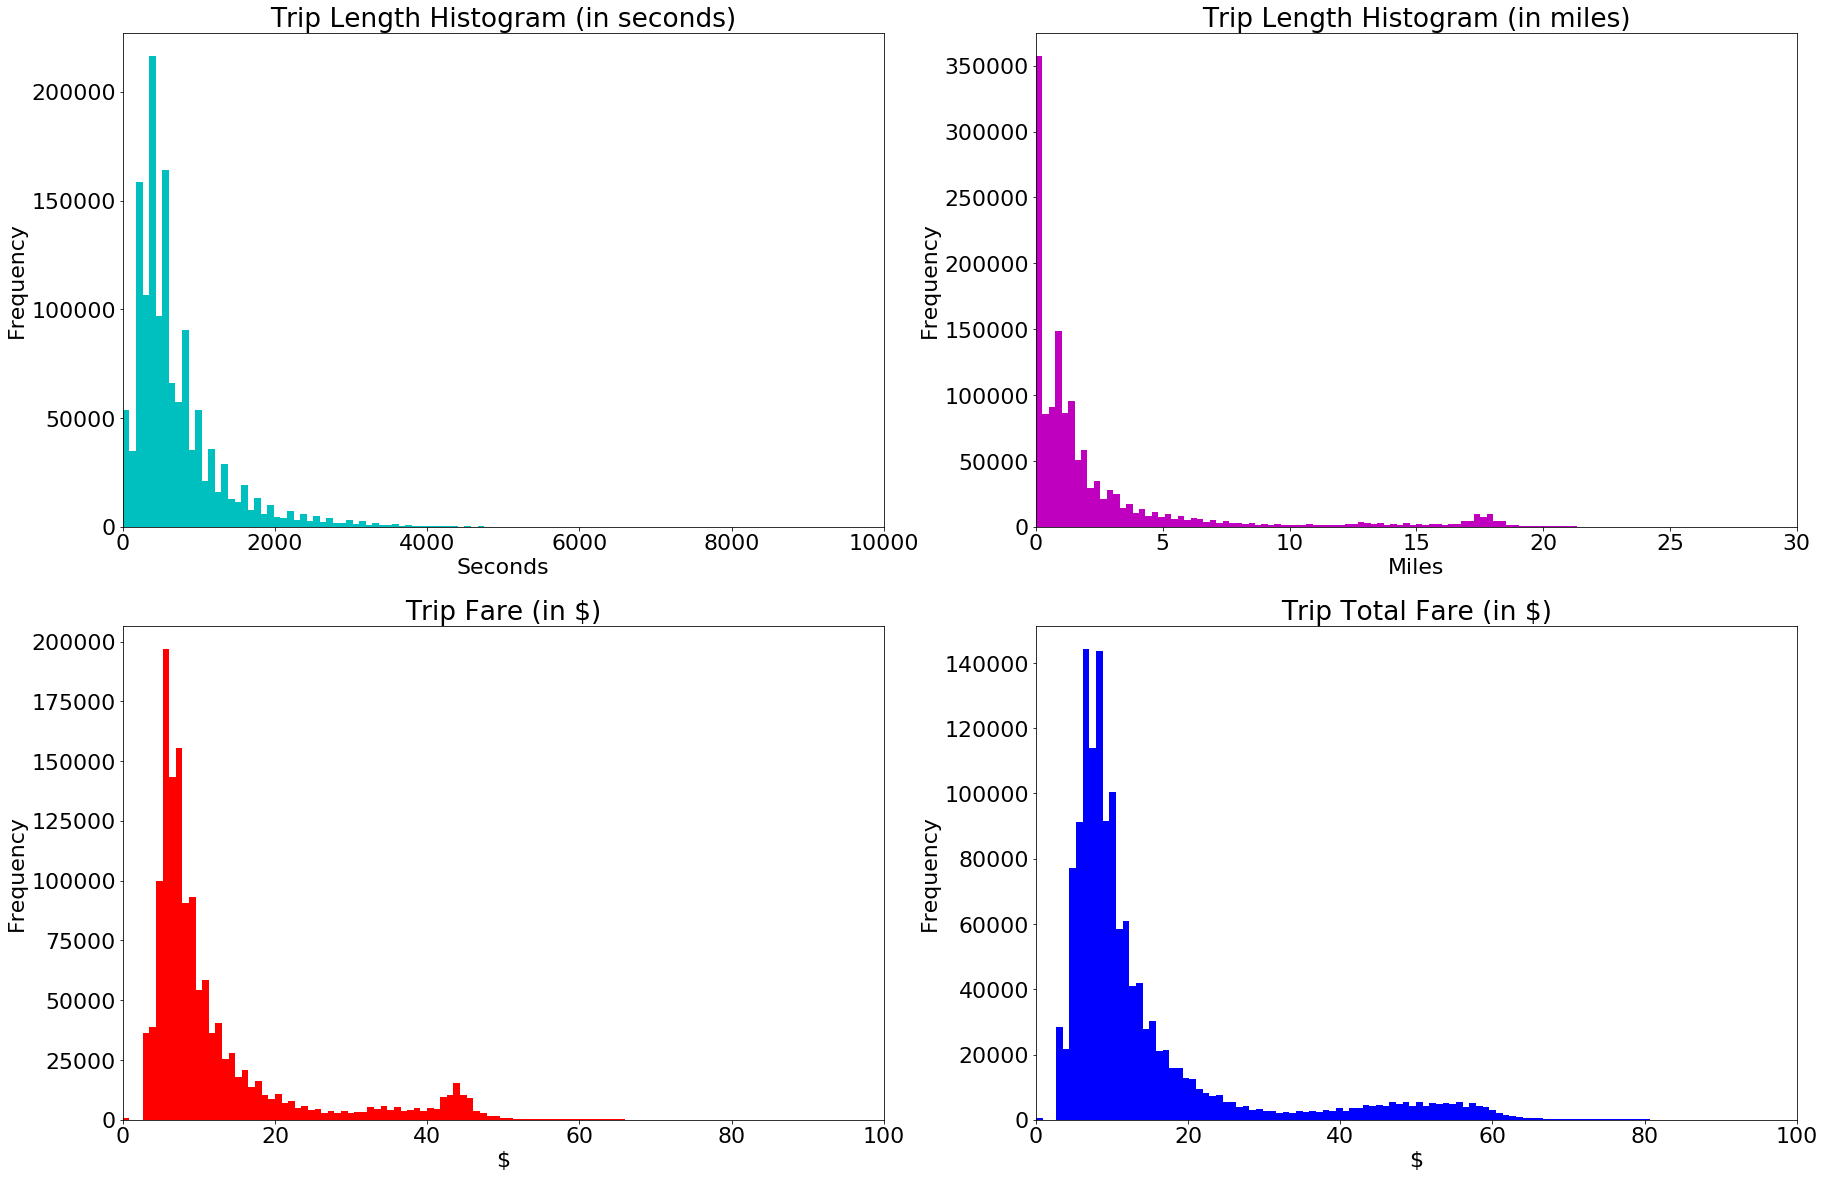

In [29]:
#Let's explore the distribution of variables of interest
plt.figure(figsize=(30, 20))
plt.rcParams.update({'font.size': 22})

plt.subplot(2, 2, 1)
plt.hist(taxi_weather_gdf['trip_seconds'].dropna(), bins=1000, color='c')
plt.title('Trip Length Histogram (in seconds)')
plt.xlim(xmin=0, xmax=10000)
plt.xlabel('Seconds')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(taxi_weather_gdf['trip_miles'].dropna(), bins=10000, color='m')
plt.title('Trip Length Histogram (in miles)')
plt.xlim(xmin=0, xmax=30)
plt.xlabel('Miles')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(taxi_weather_gdf['fare'].dropna(), bins=10000, color='r')
plt.title('Trip Fare (in $)')
plt.xlim(xmin=0, xmax=100)
plt.xlabel('$')
plt.ylabel('Frequency');

plt.subplot(2, 2, 4)
plt.hist(taxi_weather_gdf['trip_total'].dropna(), bins=10000, color='b')
plt.title('Trip Total Fare (in $)')
plt.xlim(xmin=0, xmax=100)
plt.xlabel('$')
plt.ylabel('Frequency');

In [41]:
#Let's explore the tips and tolls columns
taxi_weather_gdf.groupby(['payment_type'])['tolls'].mean()

payment_type
Cash           0.001584
Credit Card    0.000509
Dispute        0.007537
No Charge      0.000319
Pcard          0.000000
Prcard         0.000000
Unknown        0.000000
Name: tolls, dtype: float64